<p>Ben Trey<br>
Project 1<br>
Data Science Track<br>
2019/7/18<br>
</p>

Let $p_i$ be the measured probability of getting a problem correct and $P_m$ be a reward function defined as $P=\sqrt{\frac{1}{K}\sum_{k=1}^K t_k \cdot  w_k\cdot\left(1-p_k\right)^2}$, where $w_i$ is a weight depending on the student's strength on a topic, $t_i$ is a boolean variable representing a correct answer, and $K$ is the number of problems a students homework set. $p_i$ comes from the set of all possible problems for a particular homework and $P$ depends only on the problems coming from the homework belonging to one student.

Ideally you would want to maximize the reward function by fitting it to a polynomial. 

$$P( p_{rms},p_{min},p_{max}) = A + B\cdot p_{rms} + C\cdot p_{rms}^2$$



$$ \chi^2 = \sum^N_{n=1}{\left(P\left(\vec{C_n},\vec{x}_n\right)-P_n\right)^2}$$
$$ \frac{\partial \chi^2}{\partial C_m} = 2 \sum^N_{n=1}x_m\left(P\left(\vec{C_n},\vec{x}_n\right)-P_n\right)$$

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import sys
from tqdm import tqdm_notebook as tqdm

In [179]:
directory='/mnt/c/users/我的电脑/desktop/springboard/capstone'

#This class will simulate a students performance 
class Student:
    def __init__(self, school_quality, email):
        #ability represents a student's baseline math skills
        #intelligence represents a student's potential for growth
        #motivation represents a student's motivation for growth 
        #consistency represents a student's consistency in performance
        self.email = email
        self.ability = school_quality - 1.0 + 2.0*np.random.random()
        self.intelligence = school_quality - 1.0 + 2.0*np.random.random()
        self.motivation = school_quality - 1.0 + 2.0*np.random.random()
        self.consistency = school_quality - 1.0 + 2.0*np.random.random()
        self.topics={}
        self.C_list=[1.0,1.0,1.0]
        
    #problemUpdate updates the student's math ability after a correct problem    
    def problem_update(self, correct, topic, old_topic, difficulty):
        if not topic in self.topics:
            self.topics[topic]=-1.0+2.0*np.random.random()
        if not old_topic in self.topics:
            self.topics[old_topic]=-1.0+2.0*np.random.random()
        if correct:
            #increase intelligence with a certain probability
            #increase consistency with a certain probability
            #increase motivation with a certain probability
            if np.exp(self.ability) / (1+np.exp(self.ability)) > np.random.random():
                self.ability = self.ability + difficulty/100.0
            if np.exp(self.intelligence) / (1+np.exp(self.intelligence)) > np.random.random():
                self.intelligence = self.intelligence + difficulty/1000.0
            if np.exp(self.consistency)/(1+np.exp(self.consistency)) > np.random.random():
                self.consistency = self.consistency + difficulty/1000.0
            if np.exp(self.motivation)/(1+np.exp(self.motivation)) > np.random.random():
                self.motivation = self.motivation + difficulty/100.0
            if np.exp(self.topics[topic])/(1+np.exp(self.topics[topic])) >np.random.random():
                self.topics[topic] = self.topics[topic]+difficulty/100.0
            if np.exp(self.topics[old_topic])/(1+np.exp(self.topics[old_topic])) >np.random.random():
                self.topics[old_topic] = self.topics[old_topic]+difficulty/100.0
        else:
            #decrease ability with a certain probability
            #decrease intelligence with a certain probability
            #decrease consistency with a certain probability
            #decrease motivation with a certain probability
            if np.exp(self.ability)/(1+np.exp(self.ability)) < np.random.random():
                self.math_ability = self.ability - difficulty/ 100.0
            if np.exp(self.intelligence)/(1+np.exp(self.intelligence)) < np.random.random():
                self.intelligence = self.intelligence - difficulty/1000.0
            if np.exp(self.consistency)/(1+np.exp(self.consistency)) < np.random.random():
                self.consistency = self.consistency - difficulty/1000.0
            if np.exp(self.motivation)/(1+np.exp(self.motivation)) < np.random.random():
                self.motivation = self.motivation - difficulty/100.0
            if np.exp(self.topics[topic])/(1+np.exp(self.topics[topic])) < np.random.random():
                self.topics[topic] = self.topics[topic] - difficulty/100.0
            if np.exp(self.topics[old_topic])/(1+np.exp(self.topics[old_topic])) < np.random.random():
                self.topics[old_topic] = self.topics[old_topic] - difficulty/100.0
        
class School:
    def __init__(self,name):
        self.name = name
        self.school_quality=np.random.random()
        self.students = {}

class Homework:
    def __init__(self,number):
        self.number = number
        self.problem_set = []
        self.topics = set()
        
class Problem:
    def __init__(self, topic, old_topic, discipline, difficulty):
        self.topic = topic
        self.old_topic = old_topic
        self.discipline = discipline
        self.difficulty = difficulty

class Student_Profile:
    def __init__(self, real_name, user_name, password, email, school):
        self.real_name = real_name
        self.user_name = user_name
        self.password = password
        self.email = email
        self.school = school 

class Homework_Holder:
    def __init__(self):
        self.homeworks={}

def user_name_creator():
    pre=['dank', 'snarky', 'lunar', 'fiesty', 'fruity', 'spicy', 'spikey', 'slippery', 'sleepy', \
        'spooky', 'blinking', 'burping', 'sugary', 'dark', 'dinky', 'droopy', 'blind', 'hairy', \
        'hip', 'lame', 'fiery']
    fix=['tiger', 'shark', 'wheels', 'nightmare', 'guitar', 'pants', 'cat', 'blinker', 'bum', \
        'bacon', 'stinker', 'stripe', 'horse', 'monkey', 'popeye', 'eyes', 'moves', 'figher', \
        'liner', 'drifter', 'docker']
    return np.random.choice(pre) + np.random.choice(fix) + str(np.random.randint(1,1000))

def password_creator():
    chars = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890!@#$%^&*'
    password = ''
    while len(password) < 10:
        password += chars[np.random.randint(0,len(chars)-1)]
    return password

def real_name_creator():
    first = ['Abe', 'Michael', 'Blanche', 'Bobby', 'Johnny', 'Ryan', 'Jasmine', 'Sarah', 'Jenny', \
        'Josey', 'Eva', 'Wendy', 'Kelly', 'Wayne', 'Larry', 'Cindy', 'Sunny', 'Yolanda', 'Coco', \
        'Helen', 'Barette', 'Judy', 'Teddy', 'Frank', 'Victor', 'Yvonne', 'Howard', 'Richard', \
        'Angel', 'Harry', 'Sammy', 'Alex', 'Albert', 'David', 'Lester', 'Maddy', 'Patrick', \
        'Holly', 'Dan', 'Matt', 'Violet', 'Skylar', 'Patricia', 'Oscar', 'Edgar', 'Owen', 'Eric', \
        'Grace', 'Amy', 'Otto', 'Gunther', 'Franz', 'Lina', 'Nora','Angela', 'Olivia','Oliver']
    last = ['Zhang', 'Zhu', 'Ma', 'Xu', 'Wang', 'Liu', 'Li', 'Lin', 'Smith', 'Jones', 'Jackson', \
        'James', 'Johnson', 'Oneal', 'Riley', 'Maxwell', 'Baker', 'Lenz', 'Goldstein', 'Feldman', \
        'Rothschild', 'Kruger', 'Lowenstein', 'Young', 'Parker', 'Morgan', 'Barker', 'Dunn', \
        'Bradley' 'Woods', 'Jordan', 'McGrady', 'Austin', 'Hogan', 'McGuiness', 'Park']
    return np.random.choice(first) + ' ' + np.random.choice(last)

def email_creator():
    pre = ['dirty', 'milky', 'fishy', 'slimy', 'used', 'old', 'tired', 'slightly', 'mostly', \
        'found', 'lost', 'new', 'freshy', 'daily', 'buried', 'acient', 'retired', 'deep', 'moist', \
        'dry', 'hot', 'cold', 'folding', 'extra', 'replacement', 'clamy', 'soiled']
    fix = ['bread', 'beans', 'bike', 'tire', 'blanket', 'rug', 'window', 'chrysler', 'jeep', \
        'sub', 'drum', 'snake', 'shoes', 'shirt', 'hat', 'jug', 'shack', 'tide', 'spice', 'cola', \
        'cup', 'skates']
    provider = ['yahoo.com', 'gmail.com', 'outlook.com', 'qq.com', '163.com']
    return np.random.choice(pre) + np.random.choice(fix) + str(np.random.randint(1,1000)) + '@' \
        + np.random.choice(provider)

def get_data(student,homework_holder,probabilities,homework_data):
    email=student.email
    homework_number=len(homework_holder.homeworks.keys())-1
    p_data=[]
    P_data=[]
    for homework_cursor in range(homework_number):
        homework_probabilities=probabilities[probabilities['name']=='HW'+str(homework_cursor+1)]
        homework_data_frame=homework_holder.homeworks['HW'+str(homework_cursor+1)]
        user_data_frame=homework_data_frame[homework_data_frame['email']==email]
        P_sq=[]
        p_rms_sq=[]
        p_max=0                                                                                                                                                                                                                                    
        p_min=1
        for key in user_data_frame.keys():
            if user_data_frame.iloc[0][key] in [0,1]:
                topic=homework_data.iloc[homework_cursor][key+'t']
                if not topic in student.topics.keys():
                    student.topics[topic]=-1+2*np.random.random()
                topic_weight=1/(1+np.exp(student.topics[topic]))
                P_sq.append(user_data_frame.iloc[0][key]*topic_weight*(1-homework_probabilities.iloc[0][key])**2)
                p_rms_sq.append(homework_probabilities.iloc[0][key]**2)
                if homework_probabilities.iloc[0][key]>p_max:
                    p_max=homework_probabilities.iloc[0][key]
                if homework_probabilities.iloc[0][key]<p_min:
                    p_min=homework_probabilities.iloc[0][key]
        p_data.append([np.sqrt(sum(p_rms_sq)/len(p_rms_sq)),p_min,p_max])
        P_data.append([np.sqrt(sum(P_sq)/len(P_sq))])
    return [np.array(p_data),np.array(P_data)]

def get_grade(student,homework_number):
    email=student.email
    homework_data_frame=pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+'.csv')
    user_data_frame=homework_data_frame[homework_data_frame['email']==email]
    points=0
    total=0
    for key in user_data_frame.keys():
        if user_data_frame.iloc[0][key] == 1:
            points+=1
            total+=1
        elif user_data_frame.iloc[0][key]==0:
            total+=1
    return points/total*10

def get_grade_simulation(student,homework_number):
    email=student.email
    homework_data_frame=pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+'_simulation.csv')
    user_data_frame=homework_data_frame[homework_data_frame['email']==email]
    points=0
    total=0
    for key in user_data_frame.keys():
        if user_data_frame.iloc[0][key] == 1:
            points+=1
            total+=1
        elif user_data_frame.iloc[0][key]==0:
            total+=1
    return points/total*10

def get_data_csv(student,homework_number):
    email=student.email
    p_data=[]
    P_data=[]
    probabilities=pd.read_csv(directory+'/hwdata/HW_Probabilites.csv')
    homework_data=pd.read_csv(directory+'/hwdata/HWS.csv')
    for homework_cursor in range(homework_number):
        homework_probabilities=probabilities[probabilities['name']=='HW'+str(homework_cursor+1)]
        homework_dataframe=pd.read_csv(directory+'/hwdata/HW'+str(homework_cursor+1)+'.csv')
        user_data_frame=homework_dataframe[homework_dataframe['email']==email]
        P_sq=[]
        p_rms_sq=[]
        p_max=0                                                                                                                                                                                                                                    
        p_min=1
        for key in user_data_frame.keys():
            if user_data_frame.iloc[0][key] in [0,1]:
                topic=homework_data.iloc[homework_cursor][key+'t']
                if not topic in student.topics.keys():
                    student.topics[topic]=-1+2*np.random.random()
                topic_weight=1/(1+np.exp(student.topics[topic]))
                P_sq.append(user_data_frame.iloc[0][key]*topic_weight*(1-homework_probabilities.iloc[0][key])**2)
                p_rms_sq.append(homework_probabilities.iloc[0][key]**2)
                if homework_probabilities.iloc[0][key]>p_max:
                    p_max=homework_probabilities.iloc[0][key]
                if homework_probabilities.iloc[0][key]<p_min:
                    p_min=homework_probabilities.iloc[0][key]
        p_data.append([np.sqrt(sum(p_rms_sq)/len(p_rms_sq)),p_min,p_max])
        P_data.append(np.sqrt(sum(P_sq)/len(P_sq)))
    return [np.array(p_data),np.array(P_data)]

def gradient_descent(p_data, P_data, C_list, alpha, iterations):
    # p_data=np.array([[x_0,y_0,....],[x_1,y_1,.....],...])
    #P_data=np.array([[P_0],[P_1],...])
    #C_list=np.array([1,1,.....,1])
    size_of_data=len(p_data)
    size_of_poly=len(C_list)
    for n in range(iterations):
        P=np.dot(p_data,C_list).reshape(size_of_data,1)
        diff=P-P_data
        grad=np.transpose(diff)[0].dot(p_data)
        C_list=C_list-alpha*grad
    return C_list

def multi_variable_poly(p_data,max_exponent):
    #p_data.shape=(n,m), n measurements, m number of variables
    #returns array of data
    return_data=[]
    measurements=p_data.shape[0]
    num_variables=p_data.shape[1]
    term_exps=[]
    #list of lists with exponents 
    for term in range((max_exponent+1)**num_variables):
        term_exp=[]
        while len(term_exp)<num_variables:
            exponent=num_variables-len(term_exp)-1
            coefficient=term//(max_exponent+1)**exponent
            term_exp.append(coefficient)
            term-=coefficient*(max_exponent+1)**exponent
        term_exps.append(term_exp)
    #list of lists with exponents 
    for n in range(measurements):
        datum=[]
        for term_exp in term_exps:
            term=1
            for m in range(num_variables):
                term*=p_data[n][m]**term_exp[m]
            datum.append(term)
        return_data.append(datum)
    return np.array(return_data)

def machine_learning_list_hash(student,homework_holder,probabilities,homework_data):
    homework_number=len(list(homework_holder.homeworks.keys()))
    number_to_do=homework_data.iloc[homework_number-1]['number_of_problems_to_do']
    number_of_problems=homework_data.iloc[homework_number-1]['number_of_problems']
    if homework_number<4:
        problems=[]
        value = hash(student.email)
        problem_indices = list(range(number_of_problems))
        while len(problems) < number_to_do and len(problem_indices) > 0:
            problems.append(problem_indices.pop(value%len(problem_indices)))
        problems.sort()
        return problems
    else:
        #machine learning list maker
        problems=[]
        #Get data for student
        data=get_data(student,homework_holder,probabilities,homework_data)
        #Get a list of homeworks
        possible_homeworks=[]
        possible_size=10
        #min([1000,math.factorial(number_of_problems)/math.factorial(number_to_do)\
        #    /math.factorial(number_of_problems-number_to_do)])
        while len(possible_homeworks)<possible_size:
            new_homework=[1]*number_of_problems
            while sum(new_homework)>number_to_do:
                new_homework[np.random.randint(0,number_of_problems-1)]=0
            if new_homework not in possible_homeworks:
                possible_homeworks.append(new_homework) 
            #Find best fit poly
            poly_data=np.array(multi_variable_poly(data[0][:,0].reshape((homework_number-1,1)),2))
            #if homework_number==4:
            #    C_list=gradient_descent(poly_data,data[1],np.array([1.,1.,1.]),0.01,1000)
            #else:
            C_list=gradient_descent(poly_data,data[1],np.array(student.C_list),0.01,10)
            #Find best homework with poly
            best_d=0
            best_homework=[]
            probabilities_list=list(probabilities.iloc[homework_number-1].dropna())[1:]
            for homework in possible_homeworks:
                test_homework_probabilities=np.array(probabilities_list)*np.array(homework)
                p_rms=np.sqrt(np.dot(test_homework_probabilities,test_homework_probabilities)\
                    /number_to_do)
                d=(p_rms+C_list[2]/2/C_list[1])**2
                if best_d<d or d==0:
                    best_d=d
                    best_homework=homework
        return [n for n, m in enumerate(best_homework) if m != 0]

def list_hash(email,number_of_problems,number_to_do):
    problems=[]
    value = hash(email)
    problem_indices = list(range(number_of_problems))
    while len(problems) < number_to_do and len(problem_indices) > 0:
        problems.append(problem_indices.pop(value%len(problem_indices)))
    problems.sort()
    return problems

def problem_grader(student, problem):
    difficulty=problem.difficulty
    topic=problem.topic
    old_topic=problem.old_topic
    if not topic in student.topics.keys():
        student.topics[topic]=-1+2*np.random.random()
    if not old_topic in student.topics.keys():
        student.topics[old_topic]=-1+2*np.random.random()
    motivation_parameter = np.exp(student.motivation)/(1+np.exp(student.motivation))
    intelligence_parameter=np.exp(student.intelligence)/(1+np.exp(student.intelligence))
    consistency_parameter=np.exp(student.consistency)/(1+np.exp(student.consistency))
    ability_parameter=np.exp(student.ability)/(1+np.exp(student.ability))
    old_topic_parameter=np.exp(student.topics[old_topic])/(1+np.exp(student.topics[old_topic]))
    topic_parameter=np.exp(student.topics[topic])/(1+np.exp(student.topics[topic]))
    return (motivation_parameter*intelligence_parameter*topic_parameter*old_topic_parameter*\
            ability_parameter+(np.random.random()-0.5)/100/consistency_parameter) > (difficulty)**5

def data_maker():
    print('making data')
    schools = {}
    students = {}
    homework = {}
    #populate schools dictionary and write csv
    school_names = ['Chandler', 'Ahwatukee', 'Scottsdale', 'Phoenix', 'Dallas', 'Washington D.C.', \
        'Beijing', 'Shanghai', 'Bangkok', 'Mesa']
    file=open(directory+'/hwdata/schools.csv','w+')
    file.write('school_name,school_quality\r\n')
    for name in school_names:
        schools[name]=School(name)
        file.write(name+', '+str(schools[name].school_quality)+'\r\n')
    file.close()
    #populate students and school.students, write student.csv
    file=open(directory+'/hwdata/students.csv','w+')
    file.write('email,ability,intelligence,motivation,consistency\r\n')
    for name in schools.keys():
        number_of_students = 80 + np.random.randint(0,40)
        school_quality = schools[name].school_quality
        for n in range(number_of_students):
            email = email_creator()
            while email in students.keys():
                email = email_creator()
            real_name = real_name_creator()
            user_name = user_name_creator()
            password = password_creator()
            schools[name].students[email]=Student_Profile(real_name, user_name, password, email, \
                name)
            students[email]=Student(school_quality, email)
            file.write(email+','+str(students[email].ability)+','+str(students[email].intelligence)\
                +','+str(students[email].motivation)+','+str(students[email].consistency)+'\r\n')
    file.close()
    #write student info
    file=open(directory+'/hwdata/students_profile.csv','w+')
    file.write('name,user_name,password,email,school_name\r\n')
    for name in schools.keys():
        for email in schools[name].students.keys():
            real_name=schools[name].students[email].real_name
            user_name=schools[name].students[email].user_name
            password=schools[name].students[email].password
            file.write(real_name+','+user_name+','+password+','+email+','+name+'\r\n')
    file.close()
    #populate homework problems
    difficulties= [ [] for n in range(50) ]
    topics=set(['pre1','pre2','pre3','pre4','pre5'])
    for n in range(50):
        homework[n+1] = Homework(n+1)
        number_to_do = 7 + np.random.randint(0,10)
        number_of_problems = 2*number_to_do
        chapter = int(n/5) + 1
        for m in range(number_of_problems):
            topic = str(chapter) + '.' + str(6*n%10 + int(m/6))
            old_topic=random.sample(topics,1)[0]
            homework[n+1].topics.add(topic)
            difficulty = np.random.normal(0.3,0.10)
            difficulties[n].append(topic)
            difficulties[n].append(old_topic)
            difficulties[n].append('none')
            difficulties[n].append(str(difficulty))
            homework[n+1].problem_set.append(Problem(topic, old_topic, 'none', difficulty))
        for topic in homework[n+1].topics:
            topics.add(topic)
    #simulate homework problems
    line='homework_number,number_of_problems_to_do,number_of_problems'
    for n in range(1,35):
        line+=',p'+str(n)+'t,p'+str(n)+'ot,p'+str(n)+'ds,p'+str(n)+'d'
    line+='\r\n'
    homework_info_lines=[line]
    for homework_number in tqdm(range(1,51)):
        file_lines = []
        grade_lines = []
        number_of_problems = len(homework[homework_number].problem_set)
        problems_to_do = int(number_of_problems/2)
        line=str(homework_number) + ',' + str(problems_to_do) + ',' \
            + str(number_of_problems)
        for problem_number in range(number_of_problems):
            topic=homework[homework_number].problem_set[problem_number].topic
            old_topic=homework[homework_number].problem_set[problem_number].old_topic
            discipline=homework[homework_number].problem_set[problem_number].discipline
            difficulty=homework[homework_number].problem_set[problem_number].difficulty
            line+=','+topic+','+old_topic+','+discipline+','+str(difficulty)
        line+='\r\n'
        homework_info_lines.append(line)
        file_columns='email'
        for n in range(number_of_problems):
            file_columns+=(',p'+str(n+1))
        file_columns+='\r\n'
        file_lines.append(file_columns)
        for school_name in schools.keys():
            for email in schools[school_name].students.keys():
                problems_for_student = list_hash(email,number_of_problems,problems_to_do)
                scores = ['2' for n in range(number_of_problems)]
                for index in problems_for_student:
                    topic=homework[homework_number].problem_set[index].topic
                    old_topic=homework[homework_number].problem_set[index].old_topic
                    difficulty=homework[homework_number].problem_set[index].difficulty
                    score=problem_grader(students[email],\
                        homework[homework_number].problem_set[index])
                    #second attempt
                    if score == False:
                        score=problem_grader(students[email],homework[homework_number].problem_set[index])
                    scores[index] = str(int(score))
                grade_lines.append(email+','+','.join(scores)+'\r\n')
                #improving ability based on results
                for index in problems_for_student:
                    students[email].problem_update(scores[index],topic,old_topic,\
                        homework[homework_number].problem_set[index].difficulty)
        while len(grade_lines)>1:
            file_lines.append(grade_lines.pop(np.random.randint(0,len(grade_lines)-1)))
        file_lines.append(grade_lines.pop())
        file = open(directory+'/hwdata/HW' + str(homework_number) + '.csv','w+')
        for line in file_lines:
            file.write(line)
        file.close()
    file=open(directory+'/hwdata/HWS.csv','w+')
    for line in homework_info_lines:
        file.write(line)
    file.close()
    probability_writer()
    #finding average for heuristic
    print('finding average')
    homework_holder=Homework_Holder()
    for n in range(50):
        homework_holder.homeworks['HW'+str(n+1)]=pd.read_csv(directory+'/hwdata/HW'+str(n+1)+'.csv')
    probabilities=pd.read_csv(directory+'/hwdata/HW_Probabilites.csv')
    homework_data=pd.read_csv(directory+'/hwdata/HWS.csv')
    P=[]
    emails=list(students.keys())
    for n in tqdm(range(len(emails))):
        email=emails[n]
        P+=list(get_data(students[email],homework_holder,probabilities,homework_data)[1])
    file=open(directory+'/hwdata/data_maker_results.csv','w+')
    file.write('P_value\r\n')
    for datum in P:
        file.write(str(datum[0])+'\r\n')
    file.close()
    #write student_prefinal.csv
    file=open(directory+'/hwdata/students_prefinal.csv','w+')
    file.write('email,ability,intelligence,motivation,consistency,')
    topics=[]
    for email in students.keys():
        for topic in students[email].topics.keys():
            if not topic in topics:
                topics.append(topic)
    topics.sort()
    file.write(','.join([str(topic) for topi in topics])+'\r\n')
    for email in students.keys():
        file.write(email+','+str(students[email].ability)+','+str(students[email].intelligence)\
            +','+str(students[email].motivation)+','+str(students[email].consistency))
        for topic in topics:
            if topic in students[email].topics.keys():
                file.write(','+str(students[email].topics[topic]))
            else:
                students[email].topics[topic]=-1+2*np.random.random()
                file.write(','+str(students[email].topics[topic]))
        file.write('\r\n')
    file.close()
    

def get_data_maker_results():
    data_frame=pd.read_csv(directory+'/hwdata/data_maker_results.csv')
    return list(data_frame['P_value'])

def just_make_a_graph_data_maker_results():
    P=get_data_maker_results()
    print(sum(P)/len(P))
    these_bins = np.arange(0, 0.1, 0.005)
    plt.hist(P,bins=these_bins)
    plt.show()
    these_bins = np.arange(0, 0.02, 0.001)
    plt.hist(P,bins=these_bins)
    plt.show()
    grades=[]
    data=data_loader()
    students=data[1]
    homeworks=data[0]
    for n in range(len(homeworks.keys())):
        for email in students.keys():
            grades.append(get_grade(students[email],n+1))
    print(sum(grades)/len(grades))
    these_bins = np.arange(6, 10, 0.2)
    plt.hist(grades,bins=these_bins)
    plt.show()
    
    

def probability_writer():
    print('writing probability')
    line1='name'
    line2='name'
    for n in range(1,35):
        line1+=',p'+str(n)
        line2+=',p'+str(n)+'a,p'+str(n)+'c'
    line1+='\r\n'
    line2+='\r\n'
    file_lines1=[line1]
    file_lines2=[line2]
    for homework_number in range(1,51):
        line1='HW'+str(homework_number)
        line2='HW'+str(homework_number)
        data_frame=pd.read_csv(directory+'/hwdata/HW'+str(homework_number)+'.csv')
        for problem_number in range(1,len(data_frame.keys())):
            right=len(data_frame[data_frame['p'+str(problem_number)]==1])
            total=len(data_frame[data_frame['p'+str(problem_number)]!=2])
            line1+=','+str(right/total)
            line2+=','+str(total)+','+str(right)
        line1+='\r\n'
        line2+='\r\n'
        file_lines1.append(line1)
        file_lines2.append(line2)
    file=open(directory+'/hwdata/HW_Probabilites.csv','w+')
    for line in file_lines1:
        file.write(line)
    file.close()
    file=open(directory+'/hwdata/HW_Problem_History.csv','w+')
    for line in file_lines2:
        file.write(line)
    file.close()

def data_loader():
    schools = {}
    students = {}
    student_profiles={}
    homeworks = {}
    data_frame=pd.read_csv(directory+'/hwdata/schools.csv')
    for n in range(data_frame.shape[0]):
        school_name=data_frame.iloc[n]['school_name']
        schools[school_name]=School(school_name)
        schools[school_name].school_quality=data_frame.iloc[n]['school_quality']
    data_frame=pd.read_csv(directory+'/hwdata/students.csv')
    for n in range(data_frame.shape[0]):
        email=data_frame.iloc[n]['email']
        students[email]=Student(0,email)
        students[email].ability=data_frame.iloc[n]['ability']
        students[email].intelligence=data_frame.iloc[n]['intelligence']
        students[email].motivation=data_frame.iloc[n]['motivation']
        students[email].consistency=data_frame.iloc[n]['consistency']
    data_frame=pd.read_csv(directory+'/hwdata/students_profile.csv')
    for n in range(data_frame.shape[0]):
        school_name=data_frame.iloc[n]['school_name']
        email=data_frame.iloc[n]['email']
        schools[school_name].students[email]=students[email]
    for n in range(data_frame.shape[0]):
        email=data_frame.iloc[n]['email']
        real_name=data_frame.iloc[n]['name']
        user_name=data_frame.iloc[n]['user_name']
        password=data_frame.iloc[n]['password']
        school_name=data_frame.iloc[n]['school_name']
        student_profiles[email]=Student_Profile(real_name,user_name,password,email,school_name)
    data_frame=pd.read_csv(directory+'/hwdata/HWS.csv')
    for n in range(50):
        homeworks['HW'+str(n+1)]=Homework(n+1)
        number_of_problems=data_frame.iloc[n]['number_of_problems']
        for m in range(number_of_problems):
            topic=data_frame.iloc[n]['p'+str(m+1)+'t']
            old_topic=data_frame.iloc[n]['p'+str(m+1)+'t']
            discipline=data_frame.iloc[n]['p'+str(m+1)+'ds']
            difficulty=data_frame.iloc[n]['p'+str(m+1)+'d']
            homeworks['HW'+str(n+1)].topics.add(topic)
            problem=Problem(topic,old_topic,discipline,difficulty)
            homeworks['HW'+str(n+1)].problem_set.append(problem)
    return [schools,students,student_profiles,homeworks]
          
def simulation_machine_learning():
    #create dataframes to simulate hw_data.csv files
    homework_holder=Homework_Holder()
    #loading initial data from csv files
    loaded_data=data_loader()
    schools=loaded_data[0]
    students=loaded_data[1]
    student_profiles=loaded_data[2]
    homeworks=loaded_data[3]
    #read csv files
    probabilities=pd.read_csv(directory+'/hwdata/HW_Probabilites.csv')
    homework_data=pd.read_csv(directory+'/hwdata/HWS.csv')
    #running simulation
    keys=list(homeworks.keys())
    for n in tqdm(range(len(keys))):
        file_lines=[]
        homework_number=keys[n]
        #creating dataframe representing homework grades
        column_names=['email']
        number_of_problems=len(homeworks[homework_number].problem_set)
        for problem_number in range(number_of_problems):
            column_names.append('p'+str(problem_number+1))
        homework_holder.homeworks[homework_number]=pd.DataFrame(columns=column_names)
        file_columns='email'
        for m in range(number_of_problems):
            file_columns+=(',p'+str(m+1))
        file_columns+='\r\n'
        file_lines.append(file_columns)
        for email in students.keys():
            scores=[2 for i in range(number_of_problems)]
            hash_list=machine_learning_list_hash(students[email],homework_holder,probabilities,homework_data)
            for index in hash_list:
                difficulty=homeworks[homework_number].problem_set[index].difficulty
                topic=homeworks[homework_number].problem_set[index].topic
                old_topic=homeworks[homework_number].problem_set[index].old_topic
                score=problem_grader(students[email],homeworks[homework_number].problem_set[index])
                students[email].problem_update(score,topic,old_topic,difficulty)
                if score == False:
                    score=problem_grader(students[email],homeworks[homework_number].problem_set[problem_number])
                    students[email].problem_update(score,topic,old_topic,difficulty)
                scores[problem_number]=str(int(score))
            file_lines.append(email+','+','.join([str(int(score)) for score in scores])+'\r\n')
            rows=homework_holder.homeworks[homework_number].shape[0]
            homework_holder.homeworks[homework_number].loc[rows]=[email]+scores
        file=open(directory+'/hwdata/HW'+str(n+1)+'_simulation.csv','w+')
        for line in file_lines:
            file.write(line)
        file.close
    emails=list(students.keys())
    P=[]
    for n in tqdm(range(len(emails))):
        email=emails[n]
        P+=list(get_data(students[email],homework_holder,probabilities,homework_data)[1])
    file=open(directory+'/hwdata/simulation_machine_learing_results.csv','w+')
    file.write('P_value\r\n')
    for datum in P:
        file.write(str(datum[0])+'\r\n')
    file.close()
    #write student_prefinal.csv
    file=open(directory+'/hwdata/students_prefinal_machine_learning.csv','w+')
    file.write('email,ability,intelligence,motivation,consistency,')
    topics=[]
    for email in students.keys():
        for topic in students[email].topics.keys():
            if not topic in topics:
                topics.append(topic)
    topics.sort()
    file.write(','.join([str(topic) for topic in topics])+'\r\n')
    for email in students.keys():
        file.write(email+','+str(students[email].ability)+','+str(students[email].intelligence)\
            +','+str(students[email].motivation)+','+str(students[email].consistency))
        for topic in topics:
            if topic in students[email].topics.keys():
                file.write(','+str(students[email].topics[topic]))
            else:
                students[email].topics[topic]=-1+2*np.random.random()
                file.write(','+str(students[email].topics[topic]))
            file.write('\r\n')
    file.close()

def get_simulation_machine_learning_results():
    data_frame=pd.read_csv(directory+'/hwdata/simulation_machine_learing_results.csv')
    return list(data_frame['P_value'])

def just_make_a_graph_simulation_machine_learning_results():
    P=get_simulation_machine_learning_results()
    P=[float(p) for p in P]
    print(sum(P)/len(P))
    these_bins = np.arange(0, 0.1, 0.005)
    plt.hist(P,bins=these_bins)
    plt.show()       
    these_bins = np.arange(0, 0.02, 0.001)
    plt.hist(P,bins=these_bins)
    plt.show()
    grades=[]
    data=data_loader()
    students=data[1]
    homeworks=data[0]
    for n in range(len(homeworks.keys())):
        for email in students.keys():
            grades.append(get_grade_simulation(students[email],n+1))
    print(sum(grades)/len(grades))
    these_bins = np.arange(6, 10, 0.2)
    plt.hist(grades,bins=these_bins)
    plt.show()
         
        

In [62]:
data_maker()

making data


writing probability
finding average


0.018637032713044406


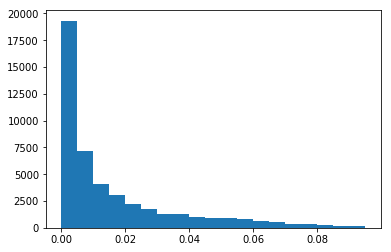

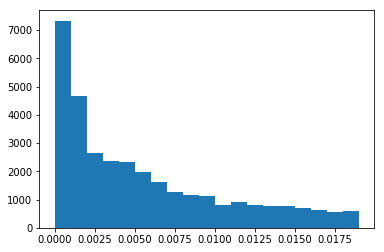

9.808869995983489


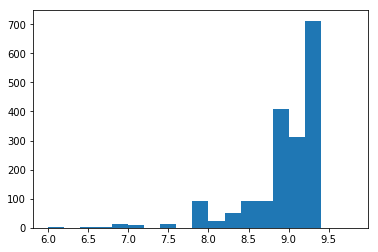

In [147]:
just_make_a_graph_data_maker_results()

In [177]:
simulation_machine_learning()

newrug243@163.com
4


SystemExit: 

/home/bentrey/myProjectDir/myProjectEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [178]:
#just_make_a_graph_simulation_machine_learning_results()

In [154]:
int(True)

1